<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v6)
Here there are two concerns:
1. Create a new dataset now that I have fixed alignment problems, and use that to train a new model and see if it has less of a problem with walls shifting over time.

2. Make the model better at correcting mistakes.

I've noticed that the model is very bad at correcting mistakes. Instead, it hallucinates extra walls and retains them - slowly shifting them to the left like all others, even while they pass through the middle of the LDS data. It finally occurred to me that the model's final 10x10 grid is not sufficiently integrated for the model to remove walls that fall _within_ the bounds of the LDS data.

So, not only do I have a problem of needing somehow to simulate training data for the model to "correct" mistakes, the architecture doesn't currently have the capacity to do such fixes.

**Idea: Self-Attention**

https://chatgpt.com/c/674b31e0-8a28-800b-8976-71d64ab86234

I need to merge information across the bottom 10x10 grid so that global state can be interpreted. The model gets too large if I just blindly follow the u-net architecture. One nice alternative is to use self-attention across the 10x10 grid

**Idea: RL fine-tuning**

One way to improve the model's ability to auto-correct mistakes (tracking mistakes, wall shifts, and wall hallucinations) is to apply a fine-tuning stage using an RL paradigm. The problem is that I need more real-world data - ie: training data more representative of what the model will experience during operation, where its inputs are a cumulative result of its outputs.

I could achieve this in an RL setting by having the agent move along trajectories through the environments while it performs SLAM. There's a couple of possible modes.

Ground-truth navigation:
* Here I use the ground-truth tracking when updating the maps. The primary concern is in the model's ability to produce accurate global maps. After an eposide, each individual step provides useful independent training data. For the map output, the loss function merely iterates through each step and compares the output map against the ground-truth map. To support ADLO training I might add a small normal error to the tracking, just like in the initial supervised learning phase. It would be hard to do much more than this for ADLO, as the input maps won't reflect errors in ADLO output.

ADLO navigation:
* Here I fully use the model's ADLO output for tracking, including in updating of the maps, with the primary concern being the accuracy of that ADLO output. This is a much more technically difficult situation because the steps in an episode are fully dependent on each other. It's problematic to penalise the system for producing a stupid result when the global map has become corrupted to the point of meaninglessness. Thus, ideally, not only would I be doing RL, but also BPTT (back-prop through time). That's tricky with the global-map in the equation, although TF magic may solve that for me.

**Idea: Just train harder**

The simpler approach may be to apply learnings from the MIT DL course:
* if you've got a bias problem, then increase the capacity of the model; don't worry about getting more data.

The thing is that my model's performing badly against the training set during the initial training. While complicated things like RL an BPTT might shift the model's biases so that it's better optimised for this particular problem, I'm getting distracted from the fundamental problem. I just need to increase the model's capacity, and train harder.

**Conclusions**

I need to get back to basics and focus on the initial SL training loss. ADLO has not been good, and I'll get a long way by just fixing that.

So:
1. Use corrected dataset.
1. Add self-attention or otherwise resolve the lack of global resolution at the bottom layer.
1. Further increase model capacity or experiment with ADLO arm architecture until I get perfect results on the training set.
1. Then try again on the animation.

After that, I should be in a good position to increase the training data and then see where I need to go next.

**First Steps**

This notebook will be about improving ADLO alone. In fact, I'm going to work with a cut-down model that only outputs ADLO.


## Further ideas - ADLO Improvements
There's so many potential things to try. Here's some ideas...

**Idea: Enrich with Coords from highest resolution**

By the time we've got to the 10x10 grid at the bottom, each grid cell represents a 16x16px window. However, due to the max-pooling on he down-scaling blocks, the value contained in there is just the most significant feature set across that 16x16px window, without any location information. Thus, using that information alone, it's impossible to be more accurate than with a +/- error of 16px.

To fix that, I should add location information onto each individual pixel on the input map, before applying max pooling. With the max-pooling in place it'll get nicely copied all the way down. At least, that's the naive thinking.

The problem with the naive thinking is that each individual channel is maxed separately, so the final result of max-pooling is of different features from a mixture of locations across the 16x16 window. Also, max-pooling against the raw location values will simply pick the largest location value. Ultimately we're no better off by the time we get to the 10x10 grid.

**Idea: ADLO through up-scale via extra Map channels**

If I were to build an image rotation detector, I'd likely go with a similar kind of U-Net approach. At the bottom 10x10 grid I'd run a _cross-attention block_ to pick out the matching features between the two images (for example, a single grid cell my represent an eye, and the task is to find the same eye in the other image). And then I'd average across them to determine the global translation and rotation. But I'd assume it to have a +/- 8px error. So on the up-scale arm I'd want to pull in information at each higher resolution to fine-tune the DLO estimate.

This makes me think I could incorporate DLO calculations into the map output arm, in extra channels. Say that I extend the final map output with 3 extra channels (delta x, delta y, delta angle). At the top level of 160x160px that's one estimate for every pixel. Then I run a dense network or something across the whole lot to compute a single ADLO.

Back to the idea DLO detector, the problem with the up-scale is that the inputs are still in their original orientation. I'd be thinking about applying the estimated DLO on the way up. But for my map output in the existing network, it seems to be working well even without that. So let's first try without that complexity.

The Conv2Transpose() operation takes a single pixel per channel, multiplies it by its 3x3 matrix, and outputs a 3x3 window. That then gets overlapped on top of shift-by-1 windows for other locations. The net result is that each output pixel is the sum of the results from 3x3 different window locations around it. And of course that's all applied throughout the depth of the tensor. That can work well if the signal from below is a DLO for each grid-cell at the lower resolution. The up-scale works by averaging across 3x3 estimates from below. Then, when it gets concatenated with information from the same resolution, it can revise its DLO estimate further.


In [1]:
# Clone repo and load its modules

import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout be28234
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam_models
import slam_data
import slam_operations
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_data)
reload(slam_operations)

Cloning into 'repo'...
remote: Enumerating objects: 883, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 883 (delta 199), reused 341 (delta 180), pack-reused 518 (from 1)
Receiving objects: 100% (883/883), 91.68 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (466/466), done.
Already up to date.


<module 'slam_operations' from '/content/repo/slam_operations.py'>

In [2]:
# Load standard libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as idisplay
import os
import sys
import math
import tqdm
import time
from timeit import default_timer as timer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Add


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Python version: {sys.version}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [3]:
# Load existing model
raw_model = tf.keras.models.load_model('slam-model-300epochs.keras')

In [4]:
# Training data
# - use model-derived training data to emulate the end of the real training loop
floorplan = slam_data.load_floorplan('repo/data/experimental-floorplan2.png')

# Load training data
if os.path.isfile('custom-training-data.npz'):
  train_data = slam_data.load_dataset('custom-training-data.npz')
else:
  print(f"Sorry, pre-generated dataset not available, you'll need to generate it.")

  np.random.seed(0)  # for consistency
  train_data = slam_data.generate_training_data(floorplan, 1000, model=raw_model)
  slam_data.validate_dataset(train_data)

  # save
  slam_data.save_dataset(train_data, 'custom-training-data.npz')

Sorry, pre-generated dataset not available, you'll need to generate it.
Generating 1000 samples of training data
Input maps: using predicted input maps with weight 1.0
Pixel size: 47.41
Max distance: 3500
Sample types: [0 1 2 3]
Mask output for sample types: (array([2]),)
Generating 95 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step
Generating training data...


100%|██████████| 1000/1000 [01:03<00:00, 15.70it/s]


Generated 1000 samples after 1000 attempts
Dataset tests passed (1000 entries verified)
Saving:
  input_maps:  (1000, 149, 149, 3)
  lds_maps:    (1000, 149, 149)
  output_maps: (1000, 149, 149, 3)
  adlos:       (1000, 4)
  metadatas:   (1000, 8)
Dataset saved to custom-training-data.npz


input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 2.3657625e+03 1.9576224e+03 1.3890883e+00]


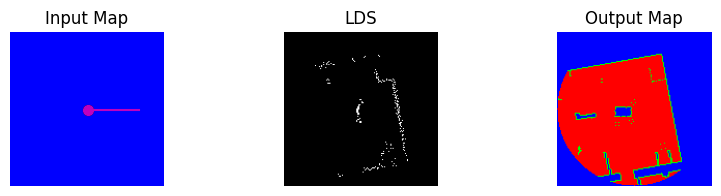

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [0. 0. 0. 0.]
metadata:   [2.0000000e+00 3.0000000e+00 1.2850688e+04 2.3075920e+03 0.0000000e+00
 6.2352432e+03 5.7653628e+03 2.3974994e-01]


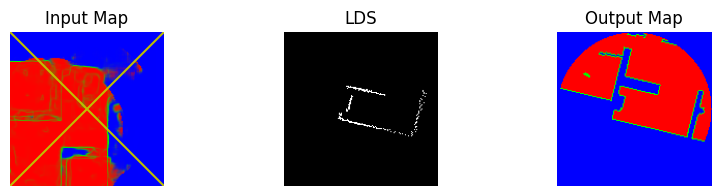

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [ 1.         -0.49413046 -0.20674904 -0.94411314]
metadata:   [2.0000000e+00 2.0000000e+00 1.2046322e+04 6.9000059e+03 0.0000000e+00
 8.5557402e+03 5.4395122e+03 9.9896175e-01]


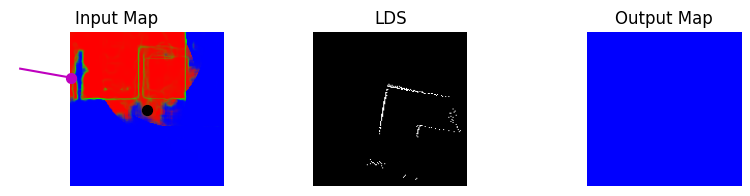

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [ 1.         -0.03253418 -0.00294744  0.0506097 ]
metadata:   [ 2.0000000e+00  1.0000000e+00  6.9862900e+03  1.3706729e+03
  0.0000000e+00  6.7564658e+03  1.3498519e+03 -2.1651773e+00]


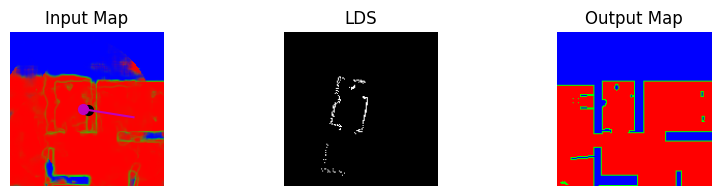

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [ 1.          0.27484012 -0.12849282  0.6290312 ]
metadata:   [ 2.0000000e+00  2.0000000e+00  4.3033867e+03  2.0717310e+03
  0.0000000e+00  6.2448818e+03  1.1640460e+03 -8.2352108e-01]


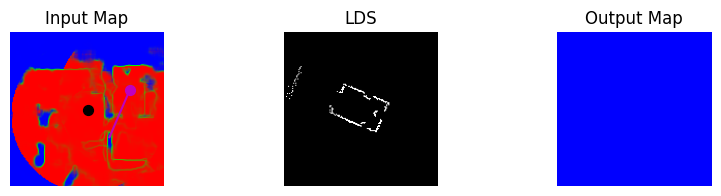

In [6]:
slam_data.show_dataset(train_data, num=5)

## Baseline model
In order to speed up the experimentation cycle time, I'm going to switch to a simpler model that only outputs ADLO. In fact, to speed up experiments further, I'll probably even build out a model that generates ADLO in multiple ways so that I can compare side-by-side really easily.

First, let's get a simple model with ADLO only and check we can train it. Also to see how this new baseline compares against our baseline from the normal model.

In [7]:
def adlo_model(map_shape, conv_filters=32, adlo_units=256, **kwargs):
    merge_mode = kwargs.get('merge_mode', 'concat')
    output_logits = kwargs.get('output_logits', True)
    do_compile = kwargs.get('compile', False)
    dlo_encoding = kwargs.get('dlo_encoding', 'linear/importance')

    # Sanity check
    if np.size(map_shape) != 3:
        raise ValueError(f"Map shape must have 3 dims, found {np.size(map_shape)}")

    # Prepare map input
    # (pad so it's a multiple of our down/up-scaling blocks)
    map_input = Input(shape=map_shape, name='map_input')
    map_down, pad_w, pad_h = slam_models.pad_block(map_input, map_shape)
    n_classes = map_shape[2]

    # Prepare LDS input
    # (convert from (B,H,W) to (B,H,W,1) to make later work easier)
    # (pad so it's a multiple of our down/up-scaling blocks)
    lds_shape = (map_shape[0], map_shape[1], 1)
    lds_input = Input(shape=(map_shape[0], map_shape[1]), name='lds_input')  # raw input omits channels axis
    lds_down = tf.keras.layers.Reshape(target_shape=lds_shape)(lds_input)
    lds_down, _, _ = slam_models.pad_block(lds_down, lds_shape)

    # Map downsampling input arm
    # (each block here returns two outputs (downsampled, convolved-only),
    #  the latter is used for skip-connections)
    map_down, map_skip1 = slam_models.slam_down_block(map_down, conv_filters)
    map_down, map_skip2 = slam_models.slam_down_block(map_down, conv_filters * 2)
    map_down, map_skip3 = slam_models.slam_down_block(map_down, conv_filters * 4)
    map_down, map_skip4 = slam_models.slam_down_block(map_down, conv_filters * 8, dropout_prob=0.3)

    # LDS downsampling input arm
    lds_down, lds_skip1 = slam_models.slam_down_block(lds_down, conv_filters)
    lds_down, lds_skip2 = slam_models.slam_down_block(lds_down, conv_filters * 2)
    lds_down, lds_skip3 = slam_models.slam_down_block(lds_down, conv_filters * 4)
    lds_down, lds_skip4 = slam_models.slam_down_block(lds_down, conv_filters * 8, dropout_prob=0.3)

    # Bottom layer
    # (combine both input arms, apply some final convolutions, leave at same scale)
    bottom = Concatenate(axis=3)([map_down, lds_down])
    bottom, _ = slam_models.slam_down_block(bottom, conv_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Accept and Delta location/orientation output
    adlo_out = slam_models.adlo_block(bottom, adlo_units, output_logits, dlo_encoding)

    model = tf.keras.Model(inputs=[map_input, lds_input], outputs=[adlo_out])

    if do_compile:
        loss = (
            slam_models.ADLOLoss(from_logits=output_logits, dlo_encoding=dlo_encoding)
        )
        metrics = {
            'adlo_output': [slam_models.ADLOLoss(from_logits=output_logits, dlo_encoding=dlo_encoding),
                            slam_models.AcceptAccuracy(),
                            slam_models.LocationError(),
                            slam_models.OrientationError()]
        }
        model.compile(optimizer='adam', loss=loss, metrics=metrics)

    print(f"Prepared SLAM model")
    print(f"  Map shape:        {map_shape} + padding ({pad_h}, {pad_w}, 0)")
    print(f"  Skip-connections: {merge_mode}")
    print(f"  Output scaling:   {'logits' if output_logits else 'scaled'}")
    print(f"  DLO encoding:     {dlo_encoding}")
    print(f"  Layers:           {len(model.layers)}")
    print(f"  Inputs:           {model.inputs}")
    print(f"  Outputs:          {model.outputs}")
    print(f"  Output names:     {model.output_names}")
    print(f"  Compiled:         {do_compile}")
    return model

Map shape: (149, 149, 3)
Batch size: 32
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Layers:           41
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=False, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_163>]
  Output names:     ListWrapper(['adlo_output'])
  Compiled:         True
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 491ms/step - accept_accuracy: 0.6033 - adlo_loss: 13.7303 - loc_error: 0.7218 - loss: 13.7359 - orientation_error: 3.7527
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accept_accuracy: 0.7467 - adlo_loss: 1.2330 - loc_error: 0.1020 - loss: 1.2332 - orientation_error: 0.1793
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accept_accuracy: 0.748

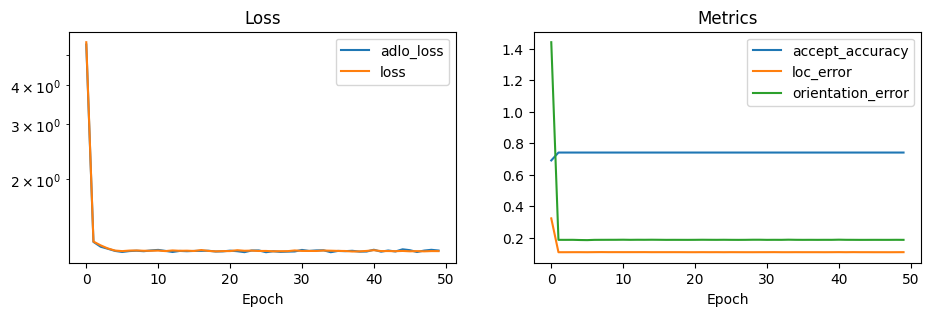

In [8]:
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)

epochs = 50
batch_size = 32
map_shape = next(iter(train_data))[0][0].shape
print(f"Map shape: {map_shape}")
print(f"Batch size: {batch_size}")

# Prepare training dataset
def for_adlo_training(inputs, outputs, metadata):
    (map_input, lds_input), (map_output, adlo_output) = inputs, outputs
    return (map_input, lds_input), adlo_output
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

# Create and compile model with default loss and metrics
model = adlo_model(map_shape, compile=True, verbose_history=True)

# Custom outer training loop that uses model.fit() for inner loop
start = timer()
model_history = tf.keras.callbacks.History()
model.fit(model_train_data, epochs=epochs, callbacks=[model_history])
duration = (timer() - start)

print(f"Total epochs: {epochs}, duration: {duration} sec")
display_history(model_history)

In [14]:
len(model_history.epoch)

50

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accept_accuracy: 0.7321 - adlo_loss: 1.1940 - loc_error: 0.1069 - loss: 1.1938 - orientation_error: 0.1912
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accept_accuracy: 0.7625 - adlo_loss: 1.1571 - loc_error: 0.1098 - loss: 1.1574 - orientation_error: 0.1843
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accept_accuracy: 0.7227 - adlo_loss: 1.1740 - loc_error: 0.1052 - loss: 1.1737 - orientation_error: 0.1793
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accept_accuracy: 0.7323 - adlo_loss: 1.2048 - loc_error: 0.1121 - loss: 1.2045 - orientation_error: 0.1989
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accept_accuracy: 0.7300 - adlo_loss: 1.2004 - loc_error: 0.1131 - loss: 1.1995 - orientation_error: 0.1909
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accept_accuracy: 0.7479 - adlo_loss: 1.1570 - loc_error: 0.1094 - loss: 1.1569 - orientation_error: 0.1782
Epoch 7/150
32/32 ━━━━━━━━━━

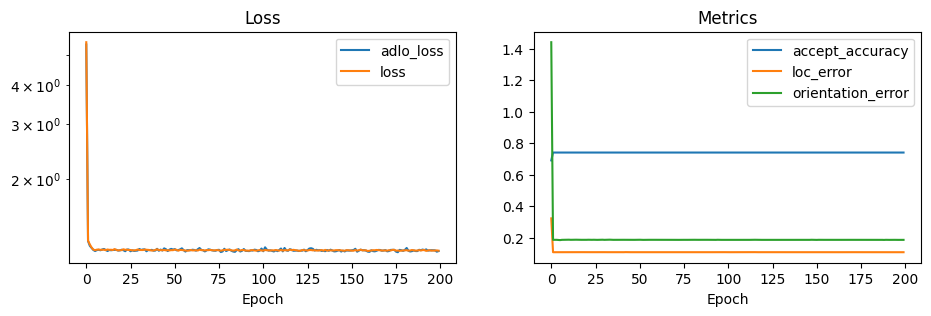

In [15]:
# optionally, do some more training
epochs = 150
start = timer()
model.fit(model_train_data, epochs=epochs, callbacks=[model_history])
duration = (timer() - start)
print(f"Total epochs: {epochs}+, duration: {duration} sec")
display_history(model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
batch:    <class 'tuple'> x 3 x (<class 'tuple'>,...)
batch[0]: <class 'tuple'> x 2
batch[0][0]: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape (5, 149, 149, 3)
batch[0][1]: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape (5, 149, 149)
batch[1]: <class 'tuple'> x 2
batch[1][0]: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape (5, 149, 149, 3)
batch[1][1]: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape (5, 4)
batch[2]: <class 'tensorflow.python.framework.ops.EagerTensor'> x 5, shape (5, 8)
preds:    <class 'numpy.ndarray'> x 5, (5, 4)
map_input: (149, 149, 3)
lds_input: (149, 149)
output_map_true: (149, 149, 3)
adlo_true: (4,)
output_map_pred: (4,)
adlo_pred: ()
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    None
adlo-pred scaled: None
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 2.3657625e+03 1.9576224e+03 1.3890883e+00]


TypeError: Invalid shape () for image data

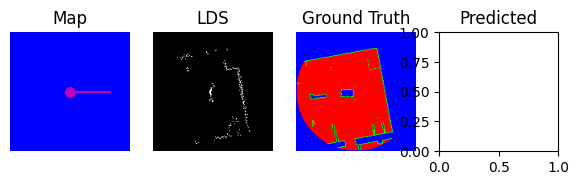

In [20]:
slam_data.show_predictions(model, train_data, num=5, flexi=True)

## ADLO with Cross-Attention
Now to experiment with a few variations.

First up, we'll just add cross-attention at the bottom layer and prove that it works.


In [ ]:
def location_embedding(input_tensor):
    """
    Adds location information to a 10x10x256 feature map as additional channels.
    Args:
        input_tensor: Tensor of shape (batch_size, 10, 10, channels).
    Returns:
        Tensor of shape (batch_size, 10, 10, channels + 2).
    """
    # Get the spatial dimensions (batch_size, height, width, channels)
    height, width = input_tensor.shape[1], input_tensor.shape[2]

    # Generate coordinate grids
    y_coords = tf.linspace(0.0, 1.0, height)  # Normalize y-coordinates [0, 1]
    x_coords = tf.linspace(0.0, 1.0, width)   # Normalize x-coordinates [0, 1]

    y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing="ij")  # Shape: (10, 10)

    # Expand to match the input tensor's batch size
    y_grid = tf.expand_dims(y_grid, axis=0)  # (1, 10, 10)
    x_grid = tf.expand_dims(x_grid, axis=0)  # (1, 10, 10)

    # Add batch and channel dimensions
    y_grid = tf.expand_dims(y_grid, axis=-1)  # (1, 10, 10, 1)
    x_grid = tf.expand_dims(x_grid, axis=-1)  # (1, 10, 10, 1)

    # Tile to match batch size
    batch_size = tf.shape(input_tensor)[0]
    y_grid = tf.tile(y_grid, [batch_size, 1, 1, 1])  # (batch_size, 10, 10, 1)
    x_grid = tf.tile(x_grid, [batch_size, 1, 1, 1])  # (batch_size, 10, 10, 1)

    # Concatenate location channels to the input tensor
    output = tf.concat([input_tensor, x_grid, y_grid], axis=-1)  # (batch_size, 10, 10, channels + 2)

    return output

def cross_attention_block(inp1, inp2, **kwargs):
  qkv_mode = kwargs.get('cross_attention_qkv_mode', 'dense')  # one of: dense, conv
  output_mode = kwargs.get('cross_attention_output_mode', 'direct')  # one of: direct, residual

  # Input shape (batch_size, 10, 10, 512)
  input_shape = tf.shape(inp1)
  spatial_dim = input_shape[1] * input_shape[2]
  channels = input_shape[-1]

  # Reshape to (batch_size, spatial_dim, channels)
  reshaped1 = tf.reshape(inp1, [-1, spatial_dim, channels])
  reshaped2 = tf.reshape(inp2, [-1, spatial_dim, channels])

  # Queries, Keys, Values
  if qkv_mode == 'dense':
    q1 = Dense(channels // 8)(reshaped1)
    k1 = Dense(channels // 8)(reshaped1)
    v1 = Dense(channels)(reshaped1)
    q2 = Dense(channels // 8)(reshaped2)
    k2 = Dense(channels // 8)(reshaped2)
    v2 = Dense(channels)(reshaped2)
  elif qkv_mode == 'conv':
    q1 = Conv2D(channels // 8, kernel_size=1, padding='same')(reshaped1)
    k1 = Conv2D(channels // 8, kernel_size=1, padding='same')(reshaped1)
    v1 = Conv2D(channels, kernel_size=1, padding='same')(reshaped1)
    q2 = Conv2D(channels // 8, kernel_size=1, padding='same')(reshaped2)
    k2 = Conv2D(channels // 8, kernel_size=1, padding='same')(reshaped2)
    v2 = Conv2D(channels, kernel_size=1, padding='same')(reshaped2)
  else:
    raise ValueError(f"Unknown cross-attention QKV mode: {qkv_mode}")

  # Cross-attention scores (batch_size, spatial_dim, spatial_dim)
  # (use query from other to query into each input)
  scores1 = tf.matmul(q2, k1, transpose_b=True)
  scores1 = tf.nn.softmax(scores1, axis=-1)
  scores2 = tf.matmul(q1, k2, transpose_b=True)
  scores2 = tf.nn.softmax(scores2, axis=-1)

  # Attended values (attention-weighted-average of values): (batch_size, spatial_dim, channels)
  attended1 = tf.matmul(scores1, v1)
  attended2 = tf.matmul(scores2, v2)

  # Reshape back to (batch_size, 10, 10, channels)
  attended1 = tf.reshape(attended1, input_shape)
  attended2 = tf.reshape(attended2, input_shape)

  # Under many self-attention networks we would now add as a residual on top of the input values,
  # but I think that's mainly to support gradient propagation. We're already within a UNet
  # which has other means for that.
  if output_mode == 'residual':
    out1 = Add()([inp1, attended1])
    out2 = Add()([inp2, attended2])
  elif output_mode == 'direct':
    out1 = attended1
    out2 = attended2
  else:
    raise ValueError(f"Unknown cross-attention output mode: {output_mode}")

  return out1, out2

def adlo_model(map_shape, conv_filters=32, adlo_units=256, **kwargs):
    merge_mode = kwargs.get('merge_mode', 'concat')
    output_logits = kwargs.get('output_logits', True)
    do_compile = kwargs.get('compile', False)
    dlo_encoding = kwargs.get('dlo_encoding', 'linear/importance')

    # Sanity check
    if np.size(map_shape) != 3:
        raise ValueError(f"Map shape must have 3 dims, found {np.size(map_shape)}")

    # Prepare map input
    # (pad so it's a multiple of our down/up-scaling blocks)
    map_input = Input(shape=map_shape, name='map_input')
    map_down, pad_w, pad_h = slam_models.pad_block(map_input, map_shape)
    n_classes = map_shape[2]

    # Prepare LDS input
    # (convert from (B,H,W) to (B,H,W,1) to make later work easier)
    # (pad so it's a multiple of our down/up-scaling blocks)
    lds_shape = (map_shape[0], map_shape[1], 1)
    lds_input = Input(shape=(map_shape[0], map_shape[1]), name='lds_input')  # raw input omits channels axis
    lds_down = tf.keras.layers.Reshape(target_shape=lds_shape)(lds_input)
    lds_down, _, _ = slam_models.pad_block(lds_down, lds_shape)

    # Map downsampling input arm
    # (each block here returns two outputs (downsampled, convolved-only),
    #  the latter is used for skip-connections)
    map_down, map_skip1 = slam_models.slam_down_block(map_down, conv_filters)
    map_down, map_skip2 = slam_models.slam_down_block(map_down, conv_filters * 2)
    map_down, map_skip3 = slam_models.slam_down_block(map_down, conv_filters * 4)
    map_down, map_skip4 = slam_models.slam_down_block(map_down, conv_filters * 8, dropout_prob=0.3)

    # LDS downsampling input arm
    lds_down, lds_skip1 = slam_models.slam_down_block(lds_down, conv_filters)
    lds_down, lds_skip2 = slam_models.slam_down_block(lds_down, conv_filters * 2)
    lds_down, lds_skip3 = slam_models.slam_down_block(lds_down, conv_filters * 4)
    lds_down, lds_skip4 = slam_models.slam_down_block(lds_down, conv_filters * 8, dropout_prob=0.3)

    # Bottom layer
    # (combine both input arms, apply some final convolutions, leave at same scale)
    map_down = location_embedding(map_down)
    lds_down = location_embedding(lds_down)
    map_down, lds_down = cross_attention_block(map_down, lds_down, **kwargs)
    bottom = Concatenate(axis=3)([map_down, lds_down])
    bottom, _ = slam_models.slam_down_block(bottom, conv_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Accept and Delta location/orientation output
    adlo_out = slam_models.adlo_block(bottom, adlo_units, output_logits, dlo_encoding)

    model = tf.keras.Model(inputs=[map_input, lds_input], outputs=[adlo_out])

    if do_compile:
        loss = (
            slam_models.ADLOLoss(from_logits=output_logits, dlo_encoding=dlo_encoding)
        )
        metrics = {
            'adlo_output': [slam_models.ADLOLoss(from_logits=output_logits, dlo_encoding=dlo_encoding),
                            slam_models.AcceptAccuracy(),
                            slam_models.LocationError(),
                            slam_models.OrientationError()]
        }
        model.compile(optimizer='adam', loss=loss, metrics=metrics)

    print(f"Prepared ADLO model with cross-attention")
    print(f"  Map shape:        {map_shape} + padding ({pad_h}, {pad_w}, 0)")
    print(f"  Skip-connections: {merge_mode}")
    print(f"  Output scaling:   {'logits' if output_logits else 'scaled'}")
    print(f"  DLO encoding:     {dlo_encoding}")
    print(f"  Layers:           {len(model.layers)}")
    print(f"  Inputs:           {model.inputs}")
    print(f"  Outputs:          {model.outputs}")
    print(f"  Output names:     {model.output_names}")
    print(f"  Compiled:         {do_compile}")
    return model

In [ ]:
reload(slam_models)
np.random.seed(42)
tf.random.set_seed(42)

epochs = 50
batch_size = 32
map_shape = next(iter(train_data))[0][0].shape
print(f"Map shape: {map_shape}")
print(f"Batch size: {batch_size}")

# Prepare training dataset
def for_adlo_training(inputs, outputs, metadata):
    (map_input, lds_input), (map_output, adlo_output) = inputs, outputs
    return (map_input, lds_input), adlo_output
model_train_data = train_data.map(for_adlo_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

# Create and compile model with default loss and metrics
model = adlo_model(map_shape, compile=True, verbose_history=True, cross_attention_qkv_mode='dense', cross_attention_output_mode='residual')

# Custom outer training loop that uses model.fit() for inner loop
start = timer()
model_history = tf.keras.callbacks.History()
model.fit(model_train_data, epochs=epochs, callbacks=[model_history])
duration = (timer() - start)

print(f"Total epochs: {epochs}, duration: {duration} sec")
display_history(model_history)